# Est ce que Fandango gonfle-t-il toujours les cotes?

En octobre 2015, Walt Hickey de FiveThirtyEight a publié [un article populaire](https://fivethirtyeight.com/features/fandango-movies-ratings/) dans lequel il présentait des preuves solides suggérant que le système de classification des films de Fandango était partial et malhonnête. Dans ce projet, nous analyserons des données de classification de films plus récentes pour déterminer s'il y a eu un changement dans le système de classification de Fandango après l'analyse de Hickey.

## Comprendre les données
Nous travaillerons avec deux échantillons de cotes de films: les données d'un échantillon ont été collectées avant l'analyse de Hickey, tandis que l'autre échantillon a été collecté après. Commençons par lire les deux exemples (qui sont stockés sous forme de fichiers CSV) et familiarisons-nous avec leur structure.

In [1]:
import pandas as pd
pd.options.display.max_columns = 50
previous = pd.read_csv('OneDrive\Documents\my_datasets\Fandango_score_comparison.csv')
after = pd.read_csv('OneDrive\Documents\my_datasets\Movie_ratings_16_17.csv')
previous.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [2]:
after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


In [3]:
fandango_previous = previous[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                             'Fandango_Difference']].copy()
fandango_after = after[['movie', 'year', 'fandango']].copy()

fandango_previous.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [4]:
fandango_after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


Notre objectif est de déterminer s'il y a eu un changement dans le système de notation de Fandango après l'analyse de Hickey. La population d'intérêt pour notre analyse est constituée de toutes les cotes de films stockées sur le site Web de Fandango, quelle que soit l'année de sortie.

Parce que nous voulons savoir si les paramètres de cette population ont changé après l'analyse de Hickey, nous souhaitons échantillonner la population à deux périodes différentes - avant et après l'analyse de Hickey - afin de pouvoir comparer les deux états.

Les données avec lesquelles nous travaillons ont été échantillonnées aux moments souhaités: un échantillon a été prélevé avant l'analyse et l'autre après l'analyse. Nous voulons décrire la population, nous devons donc nous assurer que les échantillons sont représentatifs, sinon nous devrions nous attendre à une erreur d'échantillonnage importante et, finalement, à de fausses conclusions.

De l'article de Hickey et du README.md du [référentiel de la dataset](https://github.com/fivethirtyeight/data/tree/master/fandango), nous pouvons voir qu'il a utilisé les critères d'échantillonnage suivants:

   -  Le film doit avoir eu au moins 30 cotes de fans sur le site Web de Fandango au moment de l'échantillonnage (24 août 2015).
   -  Le film devait avoir des billets en vente en 2015.
   
L'échantillonnage n'était clairement pas aléatoire car tous les films n'avaient pas la même chance d'être inclus dans l'échantillon - certains films n'avaient aucune chance du tout (comme ceux ayant moins de 30 notes de fans ou ceux sans billets en vente en 2015). On peut se demander si cet échantillon est représentatif de l'ensemble de la population que nous souhaitons décrire. Il semble plus probable que ce ne soit pas le cas, principalement parce que cet échantillon est soumis à des tendances temporelles - par ex. les films de 2015 auraient pu être remarquablement bons ou mauvais par rapport aux autres années.

Les conditions d'échantillonnage pour notre autre échantillon étaient (comme il peut être lu dans le README.md du [référentiel de la dataset](https://github.com/mircealex/Movie_ratings_2016_17)):

    - Le film doit être sorti en 2016 ou après.
    - Le film doit avoir eu un nombre considérable de votes et de critiques (on ne sait pas combien de README.md ou des données).
    
This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

## Changer le but de notre analyse

À ce stade, nous pouvons soit collecter de nouvelles données, soit modifier l'objectif de notre analyse. Nous choisissons ce dernier et imposons certaines limites à notre objectif initial.

Au lieu d'essayer de déterminer s'il y a eu un changement dans le système de notation de Fandango après l'analyse de Hickey, notre nouvel objectif est de déterminer s'il y a une différence entre les notes de Fandango pour les films populaires en 2015 et les notes de Fandango pour les films populaires en 2016. Ce nouvel objectif devrait être également une assez bonne approximation de notre objectif initial.

## Isoler les échantillons dont nous avons besoin

Avec ce nouvel objectif de recherche, nous avons deux populations d'intérêt:

   -  Toutes les cotes de Fandango pour les films populaires sortis en 2015.
   -  Toutes les cotes de Fandango pour les films populaires sortis en 2016.

Nous devons être clairs sur ce qui compte comme films populaires. Nous utiliserons la référence de Hickey de 30 évaluations de fans et ne compterons un film comme populaire que s'il a 30 évaluations de fans ou plus sur le site Web de Fandango.

Bien que l'un des critères d'échantillonnage de notre deuxième échantillon soit la popularité des films, l'échantillon ne fournit pas d'informations sur le nombre d'avis de fans. Nous devrions être sceptiques une fois de plus et nous demander si cet échantillon est vraiment représentatif et contient des films populaires (films avec plus de 30 évaluations de fans).

Un moyen rapide de vérifier la représentativité de cet échantillon est d'échantillonner au hasard 10 films à partir de celui-ci, puis de vérifier nous-mêmes le nombre de notes de fans sur le site Web de Fandango. Idéalement, au moins 8 des 10 films ont 30 évaluations de fans ou plus.

In [5]:
fandango_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Voici les évaluations des fans que nous avons trouvées:

| Movie      | Fan ratings |
| :----------- | :----------- |
|Mechanic: Resurrection |	2247|
|Warcraft |	7271|
|Max Steel |	493|
|Me Before You |	5263|
|Fantastic Beasts and Where to Find Them |	13400|
|Cell |	17|
|Genius |	127|
|Sully |	11877|
|A Hologram for the King |	500|
|Captain America: Civil War |	35057|

90% des films de notre échantillon sont populaires. Cela suffit et nous avançons avec un peu plus de confiance.

Vérifions également l'autre ensemble de données pour les films populaires. La documentation indique clairement qu'il n'y a que des films avec au moins 30 évaluations de fans, mais cela ne devrait prendre que quelques secondes pour vérifier ici.

In [6]:
sum(fandango_previous['Fandango_votes'] < 30)

0

Si vous explorez les deux ensembles de données, vous remarquerez qu'il existe des films avec une année de sortie différente de 2015 ou 2016. Pour nos besoins, nous devrons isoler uniquement les films sortis en 2015 et 2016.

Commençons par l'ensemble de données de Hickey et isolons uniquement les films sortis en 2015. Il n'y a pas de colonne spéciale pour l'année de sortie, mais nous devrions pouvoir l'extraire des chaînes de la colonne FILM.

In [7]:
fandango_previous.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5


In [8]:
fandango_previous['Year'] = fandango_previous['FILM'].str[-5:-1]
fandango_previous.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


Examinons la distribution de fréquence pour la colonne Year, puis isolons les films sortis en 2015.

In [9]:
fandango_previous['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [10]:
fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

Génial, isolons maintenant les films de l'autre DataSet.

In [11]:
fandango_after.head(2)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5


In [12]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [13]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparaison des formes de distribution pour 2015 et 2016

Notre objectif est de déterminer s'il y a une différence entre les cotes de Fandango pour les films populaires en 2015 et les cotes de Fandango pour les films populaires en 2016. Une façon de procéder consiste à analyser et comparer les distributions de cotes de films pour les deux échantillons.

Nous allons commencer par comparer la forme des deux distributions en utilisant kernel density plots. Nous utiliserons le style FiveThirtyEight pour les graphiques.

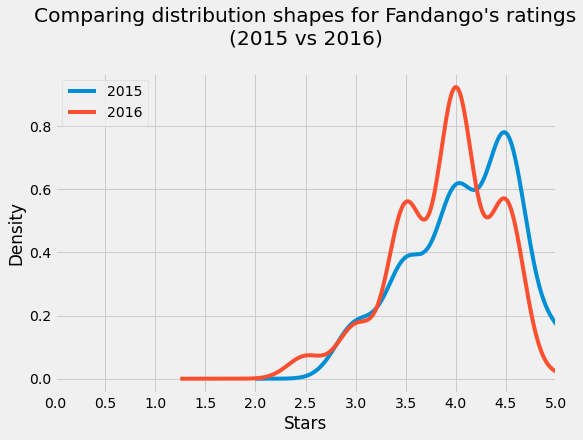

In [14]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1.07)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.show()

Deux aspects sont frappants sur la figure ci-dessus:

   -  Les deux distributions sont fortement asymétriques.
   -  La distribution de 2016 est légèrement décalée vers la gauche par rapport à la distribution de 2015.
   
Le biais de gauche suggère que les films sur Fandango reçoivent des cotes de fans principalement élevées et très élevées. Couplé au fait que Fandango vend des billets, les cotes élevées sont un peu douteuses. Il serait vraiment intéressant d'approfondir cela - Le léger décalage vers la gauche de la distribution de 2016 est très intéressant pour notre analyse. Il montre que les cotes étaient légèrement inférieures en 2016 par rapport à 2015. Cela suggère qu'il y avait effectivement une différence entre les cotes de Fandango pour les films populaires en 2015 et les cotes de Fandango pour les films populaires en 2016. Nous pouvons également voir le sens de la différence: les évaluations en 2016 étaient légèrement inférieurs à 2015.

## Comparaison des fréquences relatives

Il semble que nous suivions un bon fil jusqu'à présent, mais nous devons analyser des informations plus granulaires. Examinons les tables de fréquences des deux distributions pour analyser certains nombres. Étant donné que les ensembles de données ont des nombres de films différents, nous normalisons les tableaux et affichons des pourcentages à la place.

In [15]:
print('2015' + '\n' + '-' * 16)
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [16]:
print('2016' + '\n' + '-' * 16)
fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

En 2016, les notes très élevées (4,5 et 5 étoiles) avaient des pourcentages nettement inférieurs par rapport à 2015. En 2016, moins de 1% des films avaient une note parfaite de 5 étoiles, par rapport à 2015 où le pourcentage était proche de 7%. Les notes de 4,5 étaient également plus populaires en 2015 - il y avait environ 13% de films en plus avec une note de 4,5 en 2015 par rapport à 2016.

La note minimale est également inférieure en 2016 - 2,5 au lieu de 3 étoiles, le minimum de 2015. Il existe clairement une différence entre les deux distributions de fréquences.

Pour certaines autres cotes, le pourcentage a augmenté en 2016. Il y avait un plus grand pourcentage de films en 2016 qui ont reçu 3,5 et 4 étoiles, par rapport à 2015. 3,5 et 4,0 sont des cotes élevées et cela remet en question la direction du changement que nous avons vu sur kernel density plots.

## Déterminer la direction du changement

Prenons quelques mesures récapitulatives pour obtenir une image plus précise de la direction du changement. Dans ce qui suit, nous calculerons la moyenne, la médiane et le mode pour les deux distributions, puis utiliserons un graphique à barres pour tracer les valeurs.

In [17]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']

In [18]:
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


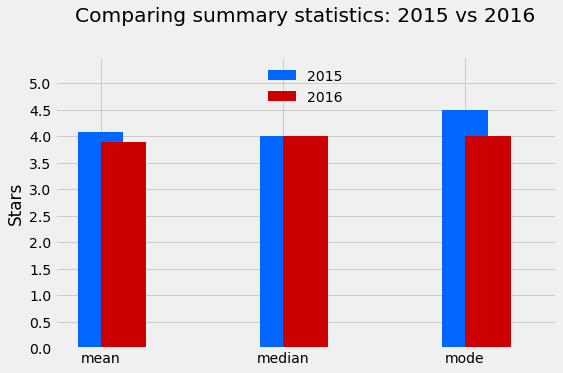

In [19]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.1)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

La note moyenne était inférieure en 2016 avec environ 0,2. Cela signifie une baisse de près de 5% par rapport à la note moyenne en 2015.

In [20]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0]

0.04842683568951993

Alors que la médiane est la même pour les deux distributions, le mode est inférieur de 0,5 en 2016. Couplé à ce que nous avons vu pour la moyenne, la direction du changement que nous avons vu sur le graphique de densité du noyau est confirmée: en moyenne, les films populaires sortis en 2016 ont été notés légèrement moins que les films populaires sortis en 2015.
Conclusion

Notre analyse a montré qu'il y avait en effet une légère différence entre les cotes de Fandango pour les films populaires en 2015 et celles de Fandango pour les films populaires en 2016. Nous avons également déterminé qu'en moyenne, les films populaires sortis en 2016 étaient moins bien notés sur Fandango que les films populaires sortis en 2015. .

Nous ne pouvons pas être complètement sûrs de la cause du changement, mais il y a de fortes chances que cela ait été causé par Fandango qui corrige le système de notation déformé après l'analyse de Hickey.